In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys
sys.path.append("../libs/")
from utils import shift_join_data, mae,rmse,mape, plot_pred, plot_history, split_df
from models import build_mlp
from keras.models import load_model
from keras.utils import plot_model, model_to_dot

Using TensorFlow backend.


# Carga de datos

In [2]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [3]:
#df_train, df_test = split_df(df, 0.3)
#df_val = df_test.copy()

In [4]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145 entries, ('DEU', 1991) to ('NZL', 2021)
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2145 non-null   float64
 1   exports      2145 non-null   float64
 2   imports      2145 non-null   float64
 3   ggfce        2145 non-null   float64
 4   gfcf         2145 non-null   float64
 5   industry     2145 non-null   float64
 6   manufact     2145 non-null   float64
 7   unempl       2145 non-null   float64
 8   agriculture  2145 non-null   float64
 9   rgdp_growth  2145 non-null   float64
 10  infl_cpi     2145 non-null   float64
 11  oil          2145 non-null   float64
 12  gold         2145 non-null   float64
 13  copper       2145 non-null   float64
 14  sp500        2145 non-null   float64
dtypes: float64(15)
memory usage: 260.6+ KB


# Dividir Datos

In [6]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [7]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [8]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'industry', 'manufact',
       'unempl', 'agriculture', 'infl_cpi', 'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


In [9]:
_, df_test = split_df(df,0.3)

# Normalizar

In [10]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

# minmax_scaler_x_train = MinMaxScaler()
# minmax_scaler_y_train = MinMaxScaler()
# minmax_scaler_x_test = MinMaxScaler()
# minmax_scaler_y_test = MinMaxScaler()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

# df_x_train.iloc[:,:] = minmax_scaler_x_train.fit_transform(df_x_train)
# df_y_train.iloc[:,:] = minmax_scaler_y_train.fit_transform(df_y_train)
# df_x_test.iloc[:,:] = minmax_scaler_x_test.fit_transform(df_x_test)
# df_y_test.iloc[:,:] = minmax_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_y_train.iloc[:,:] = np.clip(df_y_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)
df_y_test.iloc[:,:] = np.clip(df_y_test,-5,5)

# Generar variables lag y horizonte

In [11]:
n_steps_in = 9
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)

In [14]:
n_batch = len(x_train)

In [15]:
n_batch

1454

In [16]:
#mlp = build_mlp(n_steps_in,n_features,n_steps_out,304,4,1e-4,'relu')
mlp = load_model('ajustes/MLP_20220721_1701.h5')

In [17]:
history = mlp.fit(x_train,y_train,epochs=2000,batch_size=n_batch,validation_split=0.3,verbose=0,callbacks=[es],shuffle=False)

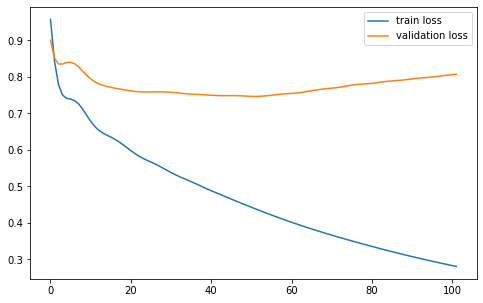

In [18]:
plot_history(history,'loss')

In [19]:
y_pred = mlp.predict(x_test)

In [20]:
# dn_y_test = minmax_scaler_y_test.inverse_transform(y_test)
# dn_y_pred = minmax_scaler_y_test.inverse_transform(y_pred)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [21]:
print(mae(dn_y_test, dn_y_pred))
print(rmse(dn_y_test, dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

[2.13835367 1.03666109 4.19258987]
[2.74116364 1.66620788 4.66328138]
[73.57653504 39.55044879 93.26796877]


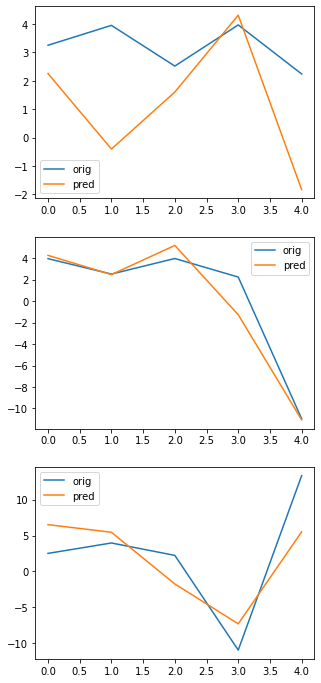

In [22]:
plot_pred(dn_y_test, dn_y_pred)

In [24]:
#plot_model(mlp,show_shapes=True,show_layer_names=True)